In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib
import boto3
import os
from pathlib import Path

In [2]:
# ###########################
# import data
# ###########################

In [3]:
# import crash data
crashes_raw = gpd.read_file('https://opendata.arcgis.com/datasets/70392a096a8e431381f1f692aaa06afd_24.geojson')

In [4]:
# import anc data
ancs = gpd.read_file('https://opendata.arcgis.com/datasets/fcfbf29074e549d8aff9b9c708179291_1.geojson')

In [5]:
# import all address points
address_points = gpd.read_file('https://opendata.arcgis.com/datasets/aa514416aaf74fdc94748f1e56e7cc8a_0.geojson')

In [46]:
# geojson version
geojson_filename = Path(home, 'address_points.geojson')
address_points.to_file(geojson_filename, driver='GeoJSON')
data = open(geojson_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='address_points.geojson', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='address_points.geojson')

In [6]:
# import census blocks
census_blocks = gpd.read_file('https://opendata.arcgis.com/datasets/a6f76663621548e1a039798784b64f10_0.geojson')

In [47]:
# geojson version
geojson_filename = Path(home, 'census_blocks.geojson')
census_blocks.to_file(geojson_filename, driver='GeoJSON')
data = open(geojson_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='census_blocks.geojson', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='census_blocks.geojson')

In [7]:
# import vision zero safety requests
vision_zero = gpd.read_file('https://opendata.arcgis.com/datasets/3f28bc3ad77f49079efee0ac05d8464c_0.geojson')

In [8]:
# 311 data
# import all 311 service requests in 2020
all311_2020 = gpd.read_file('https://opendata.arcgis.com/datasets/82b33f4833284e07997da71d1ca7b1ba_11.geojson')
# 2019
all311_2019 = gpd.read_file('https://opendata.arcgis.com/datasets/98b7406def094fa59838f14beb1b8c81_10.geojson')
# 2018
all311_2018 = gpd.read_file('https://opendata.arcgis.com/datasets/2a46f1f1aad04940b83e75e744eb3b09_9.geojson')
# 2017
all311_2017 = gpd.read_file('https://opendata.arcgis.com/datasets/19905e2b0e1140ec9ce8437776feb595_8.geojson')
# 2016
all311_2016 = gpd.read_file('https://opendata.arcgis.com/datasets/0e4b7d3a83b94a178b3d1f015db901ee_7.geojson')
# 2015
all311_2015 = gpd.read_file('https://opendata.arcgis.com/datasets/b93ec7fc97734265a2da7da341f1bba2_6.geojson')

In [9]:
# limit all the 311 requests to just traffic safety assessments, and merge them
tsa = all311_2020[all311_2020['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation']
print('2020: ', len(tsa))
tsa = tsa.append(all311_2019[all311_2019['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019: ', len(tsa))
tsa = tsa.append(all311_2018[all311_2018['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018: ', len(tsa))
tsa = tsa.append(all311_2017[all311_2017['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017: ', len(tsa))
tsa = tsa.append(all311_2016[all311_2016['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017 + 2016: ', len(tsa))
tsa = tsa.append(all311_2015[all311_2015['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017 + 2016 + 2015: ', len(tsa))

2020:  1168
2020 + 2019:  3079
2020 + 2019 + 2018:  4459
2020 + 2019 + 2018 + 2017:  5635
2020 + 2019 + 2018 + 2017 + 2016:  5937
2020 + 2019 + 2018 + 2017 + 2016 + 2015:  5959


In [10]:
# import crash details table
crash_details = gpd.read_file('https://opendata.arcgis.com/datasets/70248b73c20f46b0a5ee895fc91d6222_25.geojson')

In [11]:
for column in crash_details.columns:
    print(column)

OBJECTID
CRIMEID
CCN
PERSONID
PERSONTYPE
AGE
FATAL
MAJORINJURY
MINORINJURY
VEHICLEID
INVEHICLETYPE
TICKETISSUED
LICENSEPLATESTATE
IMPAIRED
SPEEDING
geometry


In [12]:
crash_details.PERSONTYPE.unique()

array(['Driver', 'Passenger', 'Bicyclist', 'Pedestrian'], dtype=object)

In [13]:
crash_details.MAJORINJURY.unique()

array(['N', 'Y'], dtype=object)

In [14]:
crash_details.INVEHICLETYPE.unique()

array(['Other Vehicle', 'Passenger Car/automobile', 'Bus',
       'Suv (sport Utility Vehicle)', 'Motor Cycle', 'Firearms',
       'Large/heavy Truck', 'None', 'Passenger Van',
       'Atv (all Terrain Vehicle)', 'Pickup Truck', 'Cargo Van',
       'Other Small/light Truck', 'Moped/scooter', 'Drugs/ Narcotics',
       'Construction/industrial Equipment',
       'Motorhome/camper/rv (recreational Vehicle)', 'Trailer',
       'Farm Equipment', 'Watercraft/boat', 'Snow Mobile', 'Aircraft'],
      dtype=object)

In [15]:
#######################################
# roll up crashes to crash id level
# df.groupby('A').agg({ 'B': lambda x: list(x),'C': lambda x: list(x)})
#######################################

In [15]:
# first create variables that will be aggregated
# driver over 80/driver under 25 
crash_details['DRIVERS_OVER_80']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Driver' 
                                                     and x.AGE>=80 else 0, axis = 1)
crash_details['DRIVERS_UNDER_25']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Driver' 
                                                      and x.AGE<=25 else 0, axis = 1)
# ped under 12/ped over 70 
crash_details['PEDS_OVER_70']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Pedestrian' 
                                                     and x.AGE>=70 else 0, axis = 1)
crash_details['PEDS_UNDER_12']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Pedestrian' 
                                                      and x.AGE<=12 else 0, axis = 1)
# biker under 12/biker over 70
crash_details['BIKERS_OVER_70']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Bicyclist' 
                                                     and x.AGE>=70 else 0, axis = 1)
crash_details['BIKERS_UNDER_12']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Bicyclist' 
                                                      and x.AGE<=12 else 0, axis = 1)
# out of state driver
crash_details['OOS_VEHICLES']= crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Driver' 
                                                   and x.LICENSEPLATESTATE != 'DC' else 0, axis = 1)
# vehicle type 
crash_details['CARS']=crash_details.apply(lambda x: 1 if x.INVEHICLETYPE=='Passenger Car/automobile' 
                                                    and x.PERSONTYPE=='Driver' else 0, axis = 1)
crash_details['SUVS_OR_TRUCKS']=crash_details.apply(lambda x: 1 if (x.INVEHICLETYPE=='Suv (sport Utility Vehicle)'
                                                     or x.  INVEHICLETYPE== 'Pickup Truck')
                                                    and x.PERSONTYPE=='Driver' else 0, axis = 1)

# injuries 
crash_details['PED_INJURIES']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Pedestrian' 
                                                   and (x.MAJORINJURY == 'Y' or x.MINORINJURY =='Y') else 0,
                                                        axis = 1)
crash_details['BICYCLE_INJURIES']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Bicyclist' 
                                                   and (x.MAJORINJURY == 'Y' or x.MINORINJURY =='Y') else 0,
                                                        axis = 1)
crash_details['VEHICLE_INJURIES']=crash_details.apply(lambda x: 1 if 
                                                      (x.PERSONTYPE=='Driver' or x.PERSONTYPE == 'Passenger')
                                                   and (x.MAJORINJURY == 'Y' or x.MINORINJURY =='Y') else 0,
                                                        axis = 1)
# tickets issued? 
crash_details['DRIVER_TICKETS']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Driver' 
                                                   and x.TICKETISSUED == 'Y' else 0,
                                                        axis = 1)
crash_details['BICYCLE_TICKETS']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Bicyclist' 
                                                   and x.TICKETISSUED == 'Y' else 0,
                                                        axis = 1)
crash_details['PED_TICKETS']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Pedestrian' 
                                                   and x.TICKETISSUED == 'Y' else 0,
                                                        axis = 1)
# speeding? 
crash_details['DRIVERS_SPEEDING']=crash_details.apply(lambda x: 1 if x.PERSONTYPE=='Driver' 
                                                   and x.SPEEDING == 'Y' else 0,
                                                        axis = 1)
# total injuries
crash_details['TOTAL_INJURIES']=crash_details['VEHICLE_INJURIES']+crash_details['BICYCLE_INJURIES']+crash_details['PED_INJURIES']

In [17]:
crash_details_agg = (crash_details.groupby(['CRIMEID'])
               .agg({
                    'PED_INJURIES': 'sum', 'BICYCLE_INJURIES': 'sum','VEHICLE_INJURIES': 'sum'
                     ,'TOTAL_INJURIES': 'sum', 'OOS_VEHICLES': 'sum', 'DRIVERS_UNDER_25': 'sum'
                     , 'DRIVERS_OVER_80': 'sum', 'PEDS_OVER_70':'sum', 'PEDS_UNDER_12': 'sum'
                   , 'BIKERS_OVER_70': 'sum', 'BIKERS_UNDER_12':'sum', 'OOS_VEHICLES': 'sum'
                   ,'CARS' : 'sum', 'SUVS_OR_TRUCKS' : 'sum', 'DRIVER_TICKETS': 'sum'
                   ,'BICYCLE_TICKETS': 'sum', 'PED_TICKETS':'sum', 'DRIVERS_SPEEDING': 'sum'
                  ,'PERSONTYPE': lambda x: list(x), 'INVEHICLETYPE':  lambda x: list(x), 
                   'LICENSEPLATESTATE': lambda x: list(x)
                    })
               .reset_index())

In [ ]:
#######################################
# join crashes to crash detail
#######################################

In [18]:
crash_details_agg.head()

,CRIMEID,PED_INJURIES,BICYCLE_INJURIES,VEHICLE_INJURIES,TOTAL_INJURIES,OOS_VEHICLES,DRIVERS_UNDER_25,DRIVERS_OVER_80,PEDS_OVER_70,PEDS_UNDER_12,...,BIKERS_UNDER_12,CARS,SUVS_OR_TRUCKS,DRIVER_TICKETS,BICYCLE_TICKETS,PED_TICKETS,DRIVERS_SPEEDING,PERSONTYPE,INVEHICLETYPE,LICENSEPLATESTATE
0,23411341,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,[Driver],[Motor Cycle],[PA]
1,23411387,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,1,"[Driver, Driver, Passenger]","[Passenger Car/automobile, Passenger Car/autom...","[DC, MD, DC]"
2,23411642,0,0,2,2,1,1,0,0,0,...,0,1,0,0,0,0,0,"[Passenger, Driver]","[Passenger Car/automobile, Passenger Car/autom...","[MD, MD]"
3,23411872,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,"[Pedestrian, Driver]","[None, Passenger Car/automobile]","[ None, DC]"
4,23411980,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,"[Passenger, Driver, Driver]","[Suv (sport Utility Vehicle), Suv (sport Utili...","[DC, DC, VA]"


In [19]:
# first add year to crashes
crashes_raw['YEAR'] = crashes_raw.apply(lambda x: x.FROMDATE[:4], axis=1)

In [20]:
crashes_w_detail =  crashes_raw.merge(crash_details_agg, how = 'left', on='CRIMEID')

In [21]:
for column in crashes_w_detail.columns:
    print(column)

OBJECTID
CRIMEID
CCN
REPORTDATE
ROUTEID
MEASURE
OFFSET
STREETSEGID
ROADWAYSEGID
FROMDATE
TODATE
MARID
ADDRESS
LATITUDE
LONGITUDE
XCOORD
YCOORD
WARD
EVENTID
MAR_ADDRESS
MAR_SCORE
MAJORINJURIES_BICYCLIST
MINORINJURIES_BICYCLIST
UNKNOWNINJURIES_BICYCLIST
FATAL_BICYCLIST
MAJORINJURIES_DRIVER
MINORINJURIES_DRIVER
UNKNOWNINJURIES_DRIVER
FATAL_DRIVER
MAJORINJURIES_PEDESTRIAN
MINORINJURIES_PEDESTRIAN
UNKNOWNINJURIES_PEDESTRIAN
FATAL_PEDESTRIAN
TOTAL_VEHICLES
TOTAL_BICYCLES
TOTAL_PEDESTRIANS
PEDESTRIANSIMPAIRED
BICYCLISTSIMPAIRED
DRIVERSIMPAIRED
TOTAL_TAXIS
TOTAL_GOVERNMENT
SPEEDING_INVOLVED
NEARESTINTROUTEID
NEARESTINTSTREETNAME
OFFINTERSECTION
INTAPPROACHDIRECTION
LOCATIONERROR
LASTUPDATEDATE
MPDLATITUDE
MPDLONGITUDE
MPDGEOX
MPDGEOY
BLOCKKEY
SUBBLOCKKEY
FATALPASSENGER
MAJORINJURIESPASSENGER
MINORINJURIESPASSENGER
UNKNOWNINJURIESPASSENGER
geometry
YEAR
PED_INJURIES
BICYCLE_INJURIES
VEHICLE_INJURIES
TOTAL_INJURIES
OOS_VEHICLES
DRIVERS_UNDER_25
DRIVERS_OVER_80
PEDS_OVER_70
PEDS_UNDER_12
BIKERS_O

In [21]:
len(crashes_w_detail)

239672

In [38]:
len(crashes_w_detail[(crashes_w_detail['LICENSEPLATESTATE'].isnull())])

1760

In [40]:
# s = s.astype(str)
# df["a"] = pd.to_numeric(df["a"])

crashes_w_detail['PERSONTYPE']=crashes_w_detail['PERSONTYPE'].astype(str)
crashes_w_detail['INVEHICLETYPE']=crashes_w_detail['INVEHICLETYPE'].astype(str)
crashes_w_detail['LICENSEPLATESTATE']=crashes_w_detail['LICENSEPLATESTATE'].astype(str)

In [41]:
crashes_w_detail.dtypes

OBJECTID               int64
CRIMEID                int64
CCN                   object
REPORTDATE            object
ROUTEID               object
                      ...   
PED_TICKETS          float64
DRIVERS_SPEEDING     float64
PERSONTYPE            object
INVEHICLETYPE         object
LICENSEPLATESTATE     object
Length: 80, dtype: object

In [44]:
#######################################
# upload as a json and geojson to s3
#######################################
s3 = boto3.resource('s3')
home = os.path.expanduser('~')

# geojson version
geojson_filename = Path(home, 'crashes_w_detail.geojson')
crashes_w_detail.to_file(geojson_filename, driver='GeoJSON')
data = open(geojson_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='crashes_w_detail.geojson', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='crashes_w_detail.geojson')

In [45]:
# csv version
csv_filename = Path(home, 'crashes_w_detail.csv')
crashes_w_detail.to_csv(csv_filename)
data = open(csv_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='crashes_w_detail.csv', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='crashes_w_detail.csv')

In [ ]:
#######################################
# merge census block into all datasets
#######################################

In [23]:
# CRASHES
# join crashes to data natively at census block level and add year
# do both right and left joins
census_blocks_crashes = gpd.sjoin(crashes_w_detail, census_blocks, how="left", op='intersects')
# census_blocks_crashes_right = gpd.sjoin(crashes_raw, census_blocks, how="right", op='intersects')

In [24]:
for column in census_blocks_crashes.columns:
    print(column)

OBJECTID_left
CRIMEID
CCN
REPORTDATE
ROUTEID
MEASURE
OFFSET
STREETSEGID
ROADWAYSEGID
FROMDATE
TODATE
MARID
ADDRESS
LATITUDE
LONGITUDE
XCOORD
YCOORD
WARD
EVENTID
MAR_ADDRESS
MAR_SCORE
MAJORINJURIES_BICYCLIST
MINORINJURIES_BICYCLIST
UNKNOWNINJURIES_BICYCLIST
FATAL_BICYCLIST
MAJORINJURIES_DRIVER
MINORINJURIES_DRIVER
UNKNOWNINJURIES_DRIVER
FATAL_DRIVER
MAJORINJURIES_PEDESTRIAN
MINORINJURIES_PEDESTRIAN
UNKNOWNINJURIES_PEDESTRIAN
FATAL_PEDESTRIAN
TOTAL_VEHICLES
TOTAL_BICYCLES
TOTAL_PEDESTRIANS
PEDESTRIANSIMPAIRED
BICYCLISTSIMPAIRED
DRIVERSIMPAIRED
TOTAL_TAXIS
TOTAL_GOVERNMENT
SPEEDING_INVOLVED
NEARESTINTROUTEID
NEARESTINTSTREETNAME
OFFINTERSECTION
INTAPPROACHDIRECTION
LOCATIONERROR
LASTUPDATEDATE
MPDLATITUDE
MPDLONGITUDE
MPDGEOX
MPDGEOY
BLOCKKEY
SUBBLOCKKEY
FATALPASSENGER
MAJORINJURIESPASSENGER
MINORINJURIESPASSENGER
UNKNOWNINJURIESPASSENGER
geometry
YEAR
PED_INJURIES
BICYCLE_INJURIES
VEHICLE_INJURIES
TOTAL_INJURIES
OOS_VEHICLES
DRIVERS_UNDER_25
DRIVERS_OVER_80
PEDS_OVER_70
PEDS_UNDER_12
BIK

In [25]:
# how many crashes didn't join to a census block
# crashes_null=census_blocks_crashes[(census_blocks_crashes['OBJECTID_right'].isnull()) & (census_blocks_crashes['YEAR'] == '2020')]
crashes_null=census_blocks_crashes[(census_blocks_crashes['OBJECTID_right'].isnull())]

In [26]:
len(census_blocks_crashes)

239739

In [27]:
len(crashes_null)

5374

In [ ]:
# export null crashes to a csv file so i can check it out in a db
crashes_null.to_csv('data/no_census_blocks/crashes_not_joining_to_census_block.csv')

In [ ]:
# TRAFFIC SAFETY ASSESSMENT REQUESTS
for column in tsa.columns:
    print(column)

In [48]:
# add year
tsa['YEAR'] = tsa.apply(lambda x: x.ADDDATE[:4], axis=1)

In [49]:
tsa.head()

,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,...,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,geometry,YEAR
0,1850,SPSTDAMA,Traffic Safety Investigation,Department of Transportation,DDOT,1,2020-01-02T09:33:13+00:00,1970-01-01T00:00:00+00:00,2020-07-09T10:33:13+00:00,2020-01-02T09:33:13+00:00,...,38.957468,-77.011829,WASHINGTON,DC,20011.0,245851.0,4,None,POINT (-77.01183 38.95747),2020
1,3676,SPSTDAMA,Traffic Safety Investigation,Department of Transportation,DDOT,1,2020-01-03T09:36:22+00:00,2020-01-06T09:35:16+00:00,2020-07-10T10:36:22+00:00,2020-01-03T09:36:22+00:00,...,38.900192,-76.946946,WASHINGTON,DC,20019.0,316433.0,7,None,POINT (-76.94695 38.90020),2020
2,4053,SPSTDAMA,Traffic Safety Investigation,Department of Transportation,DDOT,1,2020-01-03T13:28:34+00:00,2020-01-06T09:30:14+00:00,2020-07-10T14:28:34+00:00,2020-01-03T13:28:34+00:00,...,38.968951,-77.008830,WASHINGTON,DC,20012.0,1320.0,4,None,POINT (-77.00883 38.96896),2020
3,5418,SPSTDAMA,Traffic Safety Investigation,Department of Transportation,DDOT,1,2020-01-04T11:41:57+00:00,2020-01-06T11:25:28+00:00,2020-07-10T12:41:57+00:00,2020-01-04T11:41:57+00:00,...,38.932061,-77.072911,WASHINGTON,DC,20016.0,221531.0,3,None,POINT (-77.07291 38.93207),2020
4,6724,SPSTDAMA,Traffic Safety Investigation,Department of Transportation,DDOT,1,2020-01-05T08:30:46+00:00,2020-02-10T09:50:20+00:00,2020-07-10T09:30:45+00:00,2020-01-05T08:30:46+00:00,...,38.903961,-77.055074,WASHINGTON,DC,20037.0,274801.0,2,None,POINT (-77.05508 38.90397),2020


In [50]:
census_blocks_tsas = gpd.sjoin(tsa, census_blocks, how="left", op='intersects')

In [51]:
# how many TSAs didn't join to a census block
census_blocks_tsas_null=census_blocks_tsas[(census_blocks_tsas['OBJECTID_right'].isnull())]

In [52]:
len(census_blocks_tsas)

5964

In [53]:
len(census_blocks_tsas_null)

45

In [ ]:
# export null TSAs to a csv file so i can check it out in a db
census_blocks_tsas_null.to_csv('data/no_census_blocks/TSAs_not_joining_to_census_block.csv')

In [ ]:
# VISION ZERO REQUESTS
# first add year
for column in vision_zero.columns:
    print(column)

In [54]:
vision_zero['YEAR'] = vision_zero.apply(lambda x: x.REQUESTDATE[:4], axis=1)

In [55]:
census_blocks_vision_zero = gpd.sjoin(vision_zero, census_blocks, how="left", op='within')

In [56]:
# how many vision zero requests didn't roll up to a census block
census_blocks_vision_zero_null=census_blocks_vision_zero[(census_blocks_vision_zero['OBJECTID_right'].isnull())]

In [57]:
len(census_blocks_vision_zero)

5591

In [58]:
len(census_blocks_vision_zero_null)

58

In [ ]:
# export null records to a csv file so i can check it out in a db
census_blocks_vision_zero_null.to_csv('data/no_census_blocks/VZ_Requests_not_joining_to_census_block.csv')

In [ ]:
#######################################
# roll up by census block and year
# Merge
# Join back to census block dataset to get a geometry
#######################################

In [ ]:
# Crashes data
census_blocks_crashes['PED_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_PEDESTRIAN','MINORINJURIES_PEDESTRIAN','UNKNOWNINJURIES_PEDESTRIAN'}].sum(axis=1)
census_blocks_crashes['BICYCLE_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_BICYCLIST','MINORINJURIES_BICYCLIST','UNKNOWNINJURIES_BICYCLIST'}].sum(axis=1)
census_blocks_crashes['VEHICLE_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_DRIVER','MINORINJURIES_DRIVER','UNKNOWNINJURIES_DRIVER','MAJORINJURIESPASSENGER','MINORINJURIESPASSENGER','UNKNOWNINJURIESPASSENGER'}].sum(axis=1)

In [ ]:
census_blocks_crashes.head()

In [59]:
census_blocks_crashes['TOTAL_INJURIES']=census_blocks_crashes[{'PED_INJURIES','BICYCLE_INJURIES','VEHICLE_INJURIES'}].sum(axis=1)
census_blocks_crashes['TOTAL_FATALITIES']=census_blocks_crashes[{'FATAL_DRIVER','FATAL_BICYCLIST','FATAL_PEDESTRIAN','FATALPASSENGER'}].sum(axis=1)

In [60]:
crashes_agg = (census_blocks_crashes.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count'
                     , 'PED_INJURIES': 'sum', 'BICYCLE_INJURIES': 'sum','VEHICLE_INJURIES': 'sum'
                     ,'TOTAL_INJURIES': 'sum','TOTAL_FATALITIES': 'sum'
                    ,'OOS_VEHICLES': 'sum', 'DRIVERS_UNDER_25': 'sum', 'DRIVERS_OVER_80': 'sum', 
                     'PEDS_OVER_70': 'sum', 'PEDS_UNDER_12': 'sum', 'BIKERS_OVER_70': 'sum', 
                     'BIKERS_UNDER_12': 'sum', 'CARS': 'sum', 'DRIVERS_OVER_80': 'sum', 
                     'SUVS_OR_TRUCKS': 'sum', 'DRIVER_TICKETS': 'sum', 'BICYCLE_TICKETS': 'sum', 
                     'PED_TICKETS': 'sum', 'DRIVERS_SPEEDING': 'sum', 'TOTAL_VEHICLES': 'sum', 
                    'TOTAL_BICYCLES': 'sum', 'TOTAL_PEDESTRIANS': 'sum'
                    })
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_CRASHES'}))


In [61]:
crashes_agg.head(20)

,OBJECTID_right,YEAR,TOTAL_CRASHES,PED_INJURIES,BICYCLE_INJURIES,VEHICLE_INJURIES,TOTAL_INJURIES,TOTAL_FATALITIES,OOS_VEHICLES,DRIVERS_UNDER_25,...,BIKERS_UNDER_12,CARS,SUVS_OR_TRUCKS,DRIVER_TICKETS,BICYCLE_TICKETS,PED_TICKETS,DRIVERS_SPEEDING,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS
0,1.0,2008,4,0.0,0.0,2.0,2.0,0,5.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6,0,0
1,1.0,2010,1,0.0,0.0,0.0,0.0,0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0,0
2,1.0,2011,2,0.0,0.0,1.0,1.0,0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0
3,1.0,2012,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,7,0,0
4,1.0,2013,1,0.0,0.0,1.0,1.0,0,2.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2,0,0
5,1.0,2014,4,1.0,0.0,1.0,2.0,0,5.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,8,0,1
6,1.0,2015,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,6,0,0
7,1.0,2016,3,0.0,0.0,2.0,2.0,0,4.0,2.0,...,0.0,6.0,0.0,3.0,0.0,0.0,0.0,6,0,0
8,1.0,2017,7,1.0,0.0,1.0,2.0,0,9.0,1.0,...,0.0,13.0,0.0,5.0,0.0,0.0,0.0,17,0,1
9,1.0,2018,3,0.0,0.0,3.0,3.0,0,7.0,1.0,...,0.0,6.0,0.0,3.0,0.0,0.0,0.0,7,0,0


In [62]:
len(crashes_agg)

48829

In [ ]:
# TSA data

In [63]:
census_blocks_tsas_agg = (census_blocks_tsas.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count'})
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_TSA_REQUESTS'}))

In [64]:
census_blocks_tsas_agg.head(20)

,OBJECTID_right,YEAR,TOTAL_TSA_REQUESTS
0,1.0,2017,1
1,1.0,2018,1
2,2.0,2017,1
3,3.0,2016,1
4,3.0,2017,1
5,3.0,2018,1
6,3.0,2019,2
7,4.0,2016,1
8,4.0,2017,3
9,5.0,2018,1


In [65]:
len(census_blocks_tsas_agg)

4278

In [66]:
crashes_tsas_agg = crashes_agg.merge(census_blocks_tsas_agg, how = 'left', on=['OBJECTID_right', 'YEAR'])

In [67]:
len(crashes_tsas_agg)

48829

In [68]:
crashes_tsas_agg.head(20)

,OBJECTID_right,YEAR,TOTAL_CRASHES,PED_INJURIES,BICYCLE_INJURIES,VEHICLE_INJURIES,TOTAL_INJURIES,TOTAL_FATALITIES,OOS_VEHICLES,DRIVERS_UNDER_25,...,CARS,SUVS_OR_TRUCKS,DRIVER_TICKETS,BICYCLE_TICKETS,PED_TICKETS,DRIVERS_SPEEDING,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,TOTAL_TSA_REQUESTS
0,1.0,2008,4,0.0,0.0,2.0,2.0,0,5.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,6,0,0,NaN
1,1.0,2010,1,0.0,0.0,0.0,0.0,0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2,0,0,NaN
2,1.0,2011,2,0.0,0.0,1.0,1.0,0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0,NaN
3,1.0,2012,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,7,0,0,NaN
4,1.0,2013,1,0.0,0.0,1.0,1.0,0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2,0,0,NaN
5,1.0,2014,4,1.0,0.0,1.0,2.0,0,5.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,8,0,1,NaN
6,1.0,2015,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,6,0,0,NaN
7,1.0,2016,3,0.0,0.0,2.0,2.0,0,4.0,2.0,...,6.0,0.0,3.0,0.0,0.0,0.0,6,0,0,NaN
8,1.0,2017,7,1.0,0.0,1.0,2.0,0,9.0,1.0,...,13.0,0.0,5.0,0.0,0.0,0.0,17,0,1,1.0
9,1.0,2018,3,0.0,0.0,3.0,3.0,0,7.0,1.0,...,6.0,0.0,3.0,0.0,0.0,0.0,7,0,0,1.0


In [69]:
# vision zero data
census_blocks_vision_zero_agg = (census_blocks_vision_zero.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count'})
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_VISION_ZERO_REQUESTS'}))

In [70]:
crashes_tsas_vz_agg = crashes_tsas_agg.merge(census_blocks_vision_zero_agg, how = 'left', on=['OBJECTID_right', 'YEAR'])

In [71]:
crashes_tsas_vz_agg.head(20)

,OBJECTID_right,YEAR,TOTAL_CRASHES,PED_INJURIES,BICYCLE_INJURIES,VEHICLE_INJURIES,TOTAL_INJURIES,TOTAL_FATALITIES,OOS_VEHICLES,DRIVERS_UNDER_25,...,SUVS_OR_TRUCKS,DRIVER_TICKETS,BICYCLE_TICKETS,PED_TICKETS,DRIVERS_SPEEDING,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,TOTAL_TSA_REQUESTS,TOTAL_VISION_ZERO_REQUESTS
0,1.0,2008,4,0.0,0.0,2.0,2.0,0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,6,0,0,NaN,NaN
1,1.0,2010,1,0.0,0.0,0.0,0.0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,0,0,NaN,NaN
2,1.0,2011,2,0.0,0.0,1.0,1.0,0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,0,0,NaN,NaN
3,1.0,2012,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,7,0,0,NaN,NaN
4,1.0,2013,1,0.0,0.0,1.0,1.0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,0,0,NaN,NaN
5,1.0,2014,4,1.0,0.0,1.0,2.0,0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8,0,1,NaN,NaN
6,1.0,2015,3,0.0,0.0,2.0,2.0,0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,6,0,0,NaN,1.0
7,1.0,2016,3,0.0,0.0,2.0,2.0,0,4.0,2.0,...,0.0,3.0,0.0,0.0,0.0,6,0,0,NaN,NaN
8,1.0,2017,7,1.0,0.0,1.0,2.0,0,9.0,1.0,...,0.0,5.0,0.0,0.0,0.0,17,0,1,1.0,NaN
9,1.0,2018,3,0.0,0.0,3.0,3.0,0,7.0,1.0,...,0.0,3.0,0.0,0.0,0.0,7,0,0,1.0,NaN


In [72]:
len(crashes_tsas_vz_agg)

48829

In [73]:
geo_info = crashes_tsas_vz_agg.merge(census_blocks, how = 'inner', left_on = 'OBJECTID_right', right_on = 'OBJECTID')

In [74]:
len(geo_info)

48829

In [75]:
geo_info.geometry.name

'geometry'

In [76]:
geo_info = geo_info.set_geometry('geometry')

In [77]:
geo_info['geometry'].geom_type

0        Polygon
1        Polygon
2        Polygon
3        Polygon
4        Polygon
          ...   
48824    Polygon
48825    Polygon
48826    Polygon
48827    Polygon
48828    Polygon
Length: 48829, dtype: object

In [ ]:
# census_blocks_addr = gpd.sjoin(address_points, census_blocks, how="left", op='within')

In [78]:
# roll up address points to census block, keeping one representative row for each census block
census_blocks_addr = address_points.dissolve(by='CENSUS_BLOCK', aggfunc='first')

In [79]:
final = gpd.sjoin(geo_info, census_blocks_addr, how="left", op='intersects')

In [80]:
len(final)

48842

In [81]:
# how many vision zero requests didn't roll up to a census block
final_null=final[(final['WARD'].isnull())]

In [ ]:
final_null.to_csv('data/no_census_blocks/census_blocks_w_crash_stats_not_joining_to_address.csv')

<AxesSubplot:>

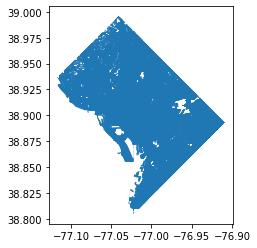

In [82]:
final.plot()

<AxesSubplot:>

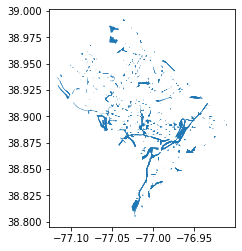

In [83]:
final_null.plot()

In [ ]:
final.head(20)

<AxesSubplot:>

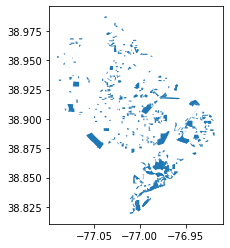

In [84]:
final[(final['PEDS_UNDER_12']>0)].plot()

<AxesSubplot:>

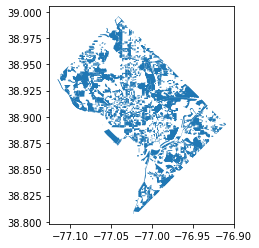

In [85]:
final[(final['DRIVERS_OVER_80']>0)].plot()

In [ ]:
final.to_csv('data/merged/merged_v1.csv')

In [ ]:
final_2020 = final[final['YEAR'] == '2020']

In [ ]:
final_2020.to_file("data/merged/merged_v1_2020.geojson", driver='GeoJSON')

In [ ]:
#######################################
# PUT EVERYTHING IN AN S3 BUCKET
#######################################

In [86]:
# geojson version
geojson_filename = Path(home, 'census_block_level_final.geojson')
crashes_w_detail.to_file(geojson_filename, driver='GeoJSON')
data = open(geojson_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='census_block_level_final.geojson', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='census_block_level_final.geojson')

In [87]:
# csv version
csv_filename = Path(home, 'census_block_level_final.csv')
crashes_w_detail.to_csv(csv_filename)
data = open(csv_filename, 'rb')
s3.Bucket('dc-crash-bot-test').put_object(Key='census_block_level_final.csv', Body=data)

s3.Object(bucket_name='dc-crash-bot-test', key='census_block_level_final.csv')

In [ ]:
#######################################
# OLD CODE
# keeping it to refer back to
#######################################

In [ ]:
# join crashes to data natively at ANC level and add year
anc_crashes = gpd.sjoin(crashes_raw, ancs, how="inner", op='within')
anc_crashes['YEAR'] = anc_crashes.apply(lambda x: x.REPORTDATE[:4], axis=1)
#Number of crashes thus far in 2020 by ANC
pd.DataFrame(anc_crashes.groupby(['YEAR', 'NAME']).size()).loc['2020']

In [ ]:
# try to roll up address points to desired level
# roll up address points to census block 
census_blocks = address_points.dissolve(by='CENSUS_BLOCK', aggfunc='first')

In [ ]:
census_blocks.head()

In [ ]:
# check geo type
census_blocks['geometry'].geom_type

In [ ]:
len(census_blocks)

In [ ]:
# remove points so census blocks can be rolled up to polygons
census_blocks=census_blocks[census_blocks['geometry'].geom_type != 'Point']

In [ ]:
# check how many fell out
len(census_blocks)

In [ ]:
# limit the census blocks dataset to census blocks that can become polygons
census_blocks = census_blocks[census_blocks['geometry'].apply(lambda x: len(list(x)) > 2)]

In [ ]:
len(census_blocks)

In [ ]:
census_block_polygons=census_blocks.copy()

In [ ]:
# convert to polygons
census_block_polygons['geometry'] = census_block_polygons.apply(lambda x: Polygon(x.geometry), axis=1)

In [ ]:
len(census_block_polygons)

In [ ]:
len(crashes_raw)

In [ ]:
# roll up crashes by census block
crashes = gpd.sjoin(crashes_raw, census_block_polygons, how="left", op='within')

In [ ]:
len(crashes)

In [ ]:
crashes['YEAR'] = crashes.apply(lambda x: x.REPORTDATE[:4], axis=1)

In [ ]:
#do a sanity check on number of crashes by year and ward
ward_year_rollup=pd.DataFrame(crashes.fillna(-1).groupby(['YEAR', 'WARD_right', 'WARD_left']).size())

In [ ]:
ward_year_rollup.to_excel('crashes_by_year_and_ward.xlsx')

In [ ]:
# how many crashes in 2020 didn't join to a census block
crashes_null=crashes[(crashes['WARD_right'].isnull()) & (crashes['YEAR'] == '2020')]

In [ ]:
len(crashes_null)

In [ ]:
# check distance between address points objectid 846387/MARID 15323 and all of the crashes listed at that MARID
crash_sample = crashes_raw.loc[crashes_raw['MARID'] == 15232]

In [ ]:
addr_sample = address_points.loc[address_points['ADDRESS_ID'] == 15232]

In [ ]:
for point in crash_sample['geometry']:
    print(point.distance(addr_sample['geometry'].iloc[0]))

In [ ]:
address_points_buf = address_points.copy()
address_points_buf['geometry'] = address_points_buf.apply(lambda x: x.geometry.buffer(0.0003), axis=1)